<a href="https://colab.research.google.com/github/JCaballerot/Deep_learning_program/blob/main/RBM_Recommender/MovieLens_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align="center"><font size="5"> SISTEMAS DE RECOMENDACION USANDO RESTRICTED BOLTZMANN MACHINE</font></h1>

Bienvenido al laboratorio <b>Sistema de recomendaciones usando restricted Boltzmann machine's</b>. En este cuaderno, estudiamos y repasamos el uso de una máquina restringida de Boltzmann (RBM) en un sistema de recomendación basado en colaborative filtering. Este sistema es un algoritmo que recomienda elementos al tratar de encontrar usuarios que sean similares entre sí en función de las calificaciones de sus elementos. Al final de este laboratorio, debería tener una comprensión más profunda de cómo se aplican las máquinas restringidas de Boltzmann y cómo crear una con TensorFlow.

<h2>Tabla de Contenidos</h2>

<ol>
    <li><a href="#ref1">Obtener la data</a></li>
    <li><a href="#ref2">Carga de la data</a></li>
    <li><a href="#ref3">El modelo de Restricted Boltzmann machine</a></li>
    <li><a href="#ref4">Configuración de los parámetros del modelo</a></li>
    <li><a href="#ref5">Recomendación</a></li>
</ol>
<br>
<br>
<hr>

<a id="ref1"></a>
<h2>Obtener la Data</h2>

Para empezar, necesitamos descargar los datos que vamos a utilizar para nuestro sistema. Los conjuntos de datos que vamos a usar fueron adquiridos por <a href="http://grouplens.org/datasets/movielens/"> GroupLens </a> y contienen películas, usuarios y calificaciones de películas de estos usuarios.

Después de descargar los datos, extraeremos los conjuntos de datos a un directorio que sea de fácil acceso.

In [ ]:
!pip3 install tensorflow

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0

In [ ]:
import tensorflow as tf
#print(tf.__version__)

In [ ]:
!wget -O moviedataset.zip https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/moviedataset.zip
print('unziping ...')
!unzip -o -j moviedataset.zip

--2023-06-22 03:17:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/moviedataset.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 152.88M  30.9MB/s    in 4.7s    

2023-06-22 03:17:35 (32.8 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: tags.csv                


Con los conjuntos de datos en su lugar, ahora importemos las bibliotecas necesarias. Usaremos <a href="https://www.tensorflow.org/"> Tensorflow </a> y <a href="http://www.numpy.org/"> Numpy </a> juntos para modelar e inicializar nuestra máquina restringida de Boltzmann y <a href="http://pandas.pydata.org/pandas-docs/stable/"> Pandas </a> para manipular nuestros conjuntos de datos. Para importar estas bibliotecas, ejecute la celda de código a continuación.

In [ ]:
#Tensorflow
import tensorflow as tf
#Numpy
import numpy as np
#Pandas
import pandas as pd
#Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
tf.__version__

'1.14.0'

<hr>

<a id="ref2"> </a>
<h2> Carga de la data</h2>

Comencemos cargando nuestros datos con Pandas. Los archivos .dat que contienen nuestros datos son similares a los archivos CSV, pero en lugar de usar el carácter ',' (coma) para separar entradas, usa caracteres '::' (dos dos puntos). Para que Pandas sepa que debe separar puntos de datos en cada '::', tenemos que especificar el parámetro <code> sep = '::' </code> al llamar a la función.

Además, también le pasamos el parámetro <code> header = None </code> debido al hecho de que nuestros archivos no contienen ningún encabezado.

Comencemos con el archivo movies.dat y echemos un vistazo a su estructura:

In [ ]:
#Cargando nuestro dataset de peliculas
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Podemos hacer lo mismo con el archivo ratings.dat:

In [ ]:
#Cargando los puntajes de las películas
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


Por lo tanto, nuestra variable <b>movies_df</b> contiene un marco de datos que almacena el número de identificación, el título y los géneros únicos de una película, mientras que nuestra variable <b>ratings_df</b> almacena un número de identificación de usuario único, la identificación de una película que el usuario ha visto, la calificación del usuario para dicha película y cuándo el usuario calificó esa película.

Cambiemos el nombre de las columnas en estos marcos de datos para que podamos transmitir mejor sus datos de manera más intuitiva:

In [ ]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies_df[movies_df.MovieID == 48516]

,MovieID,Title,Genres
11372,48516,"Departed, The (2006)",Crime|Drama|Thriller


y ratings_df:

In [ ]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


<hr>

<a id="ref3"></a>
<h2>El modelo de Restricted Boltzmann Machine's</h2>

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width="300">
<br>
El modelo de la máquina restringida de Boltzmann tiene dos capas de neuronas, una de las cuales es lo que llamamos una capa de entrada visible y la otra se llama capa oculta. La capa oculta se utiliza para aprender características de la información que se alimenta a través de la capa de entrada. Para nuestro modelo, la entrada contendrá X neuronas, donde X es la cantidad de películas en nuestro conjunto de datos. Cada una de estas neuronas poseerá un valor de calificación normalizado que varía de 0 a 1, donde 0 significa que un usuario no ha visto esa película y cuanto más cerca está el valor de 1, más le gusta al usuario la película que representa la neurona. Estos valores normalizados, por supuesto, se extraerán y normalizarán del conjunto de datos de calificaciones.

Después de pasar la entrada, entrenamos el RBM en ella y hacemos que la capa oculta aprenda sus características. Estas funciones son las que usamos para reconstruir la entrada, que en nuestro caso, predecirá las calificaciones de las películas que el usuario no ha visto, ¡que es exactamente lo que podemos usar para recomendar películas!

Ahora comenzaremos a formatear nuestro conjunto de datos para seguir la entrada esperada del modelo.

<h3>Formateando la Data</h3>

Primero veamos cuántas películas tenemos y veamos si los ID de la película se corresponden con ese valor:

In [ ]:
movies_df.shape

(34208, 3)

In [ ]:
ratings_df = ratings_df.drop('Timestamp', 1)

<ipython-input-16-6e9e435db81f>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ratings_df = ratings_df.drop('Timestamp', 1)


In [ ]:
ratings_df.shape

(22884377, 3)

In [ ]:
ratings_df = ratings_df.loc[ratings_df.UserID <= 1000]
ratings_df.head()
ratings_df.shape

(93993, 3)

In [ ]:
ratings_df.shape

(93993, 3)

Ahora, podemos comenzar a formatear los datos en entrada para el RBM. Vamos a almacenar las calificaciones de usuarios normalizadas en una matriz de calificación de usuarios llamada trX y normalizar los valores.

In [ ]:
ratings_df.head()

,UserID,MovieID,Rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


In [ ]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,147392,147394,147396,147398,148238,148626,148652,148667,148683,150548
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalizamos la data:

In [ ]:
norm_user_rating_df = user_rating_df.fillna(0)/ 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<hr>

<a id="ref4"></a>
<h2>Seteando los parámetros del modelo</h2>

A continuación, comencemos a construir nuestro RBM con TensorFlow. Comenzaremos determinando primero la cantidad de neuronas en las capas ocultas y luego creando variables de marcador de posición para almacenar nuestros sesgos de capa visible, sesgos de capa oculta y pesos que conectan la capa oculta con la capa visible. Estableceremos arbitrariamente el número de neuronas en las capas ocultas en 20. Puede establecer libremente este valor en cualquier número que desee, ya que cada neurona en la capa oculta terminará aprendiendo una característica.

In [ ]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()



In [ ]:

hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)

vb = tf.placeholder("float", [visibleUnits]) #Número de películas únicas
hb = tf.placeholder("float", [hiddenUnits]) #Número de caracteristicas que vamos a aprender
W  = tf.placeholder("float", [visibleUnits, hiddenUnits])


Luego pasamos a crear las unidades de capa visibles y ocultas y establecer sus funciones de activación. En este caso, usaremos las funciones <code> tf.sigmoid </code> y <code> tf.relu </code> como activaciones no lineales ya que se usa comúnmente en RBM.

In [ ]:
#Phase 1: Input Procesamiento
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

#Phase 2: Reconstrucción
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)


Ahora configuramos los parámetros y funciones de entrenamiento para nuestro RBM.

In [ ]:
#Learning rate
alpha = 1.0

#Crear gradientes
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

#Calcule la divergencia de contraste para maximizar
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

#Crear métodos para actualizar las ponderaciones y bias.
update_w  = W  + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)


Instructions for updating:
Use `tf.cast` instead.


Y configuramos la función de error, que en este caso será la función de error absoluto medio.

In [ ]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)


También tenemos que inicializar nuestras variables. Afortunadamente, NumPy tiene una práctica función <code> zeros </code> para esto. Lo usamos así:

In [ ]:
#Peso actual
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

#Bias actuales de unidades visibles
cur_vb = np.zeros([visibleUnits], np.float32)

#Bias actuales de unidades ocultas
cur_hb = np.zeros([hiddenUnits], np.float32)

#Peso anterior
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

#Sesgos de unidades visibles anteriores
prv_vb = np.zeros([visibleUnits], np.float32)

#Sesgos anteriores de unidades ocultas
prv_hb = np.zeros([hiddenUnits], np.float32)


sess = tf.Session()
sess.run(tf.global_variables_initializer())


Ahora entrenamos el RBM con 15 epochs con cada epoch usando 10 batch con tamaño 100. Después del entrenamiento, imprimimos un gráfico con el error por epoch.

epoch  0  error:  0.10407622
epoch  1  error:  0.0604242
epoch  2  error:  0.043767016
epoch  3  error:  0.035079524
epoch  4  error:  0.029409332
epoch  5  error:  0.025299598
epoch  6  error:  0.022780197
epoch  7  error:  0.020944016
epoch  8  error:  0.01943359
epoch  9  error:  0.018101094
epoch  10  error:  0.017243713
epoch  11  error:  0.016238486
epoch  12  error:  0.015771957
epoch  13  error:  0.015175838
epoch  14  error:  0.0147530995


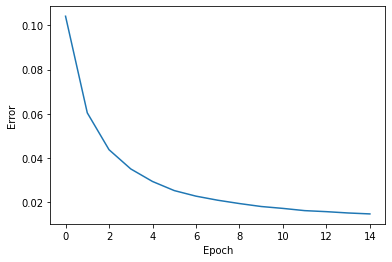

In [ ]:
epochs = 15
batchsize = 100
errors = []

for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("epoch ", str(i) , " error: " , errors[-1])

plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<hr>

<a id="ref5"></a>
<h2>Recomendación</h2>

Ahora podemos predecir películas que podrían gustarle a un usuario seleccionado arbitrariamente. Esto se puede lograr introduciendo las preferencias de películas vistas del usuario en el RBM y luego reconstruyendo la entrada. Los valores que nos da el RBM intentarán estimar las preferencias del usuario por las películas que no ha visto en función de las preferencias de los usuarios en los que se entrenó el RBM.

Primero seleccionemos un <b>User ID</b> de nuestra data:

In [ ]:
mock_user_id = 2

In [ ]:
#Seleccionando al usuario input
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#Puntuar al usuario y reconstruir la entrada
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec)

[[0.2074874  0.03532395 0.03880036 ... 0.00056949 0.00100023 0.00082035]]


Luego, podemos enumerar las 20 películas más recomendadas para nuestro usuario simulado clasificándolas por sus puntajes dados por nuestro modelo.

In [ ]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.920026
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.771953
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.586895
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.573784
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.547758
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.453711
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0.330595
843,858,"Godfather, The (1972)",Crime|Drama,0.309332
1242,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,0.296884
108,110,Braveheart (1995),Action|Drama|War,0.295827


Entonces, ¿cómo recomendar las películas que el usuario aún no ha visto?

Ahora, podemos encontrar todas las películas que nuestro usuario ha visto antes:

In [ ]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating
3,2,2571,3.5
4,2,109487,4.0
5,2,112552,5.0
6,2,112556,4.0


En la siguiente celda, cruzamos todas las películas que nuestro usuario ha visto con los puntajes predichos basados en sus datos históricos:

In [ ]:
#Cruzandi movies_df con ratings_df por MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

ordenemos y echemos un vistazo a las primeras 20 filas:

In [ ]:
merged_df_mock.sort_values(["Rating"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating
8815,112552,Whiplash (2014),Drama,0.086818,2.0,5.0
8743,109487,Interstellar (2014),Sci-Fi|IMAX,0.096587,2.0,4.0
8816,112556,Gone Girl (2014),Drama|Thriller,0.026781,2.0,4.0
2019,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.573784,2.0,3.5
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.207487,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.035324,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,0.038800,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.001065,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,0.018532,NaN,NaN
5,6,Heat (1995),Action|Crime|Thriller,0.038392,NaN,NaN


Como puede ver, hay algunas películas que el usuario aún no ha visto y tiene una puntuación alta según nuestro modelo. Entonces, podemos recomendarlos al usuario.

Puede intentar cambiar los parámetros en el código: agregar más unidades a la capa oculta, cambiar las funciones de pérdida o tal vez algo más para ver si cambia algo. ¿El modelo funciona mejor? ¿Se tarda más en calcular?


<hr>

### Gracias por completar este laboratorio!